In [15]:
# from LengyelReinkeFormulation import LengFunc,returnImpurityFracLeng
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad,trapz, cumtrapz, odeint, solve_ivp
from scipy import interpolate
import ThermalFrontFormulation as TF
from unpackConfigurations import unpackConfiguration,returnzl,returnll
from matplotlib.collections import LineCollection
from AnalyticCoolingCurves import LfuncN,LfunLengFunccGauss,LfuncNe, LfuncAr

%matplotlib inline
%load_ext autoreload
%autoreload 2
%aimport LengyelReinkeFormulation
from LengyelReinkeFormulation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#import geometry
gridFile = "testGrids\\ConnectionLength\\L1.00.nc"

d = dict()
d["zl"],d["TotalField"],d["Xpoint"],d["R0"],d["Z0"],d["R"],d["Z"], d["polLengthArray"], d["Bpol"], d["S"] = unpackConfiguration(gridFile,"Box",zxoverL = 0.7, returnSBool = True,polModulator = 1,sepadd = 0)

d["Xpoint"] = len(d["S"])-1 # Code incorrectly defaults to an xpoint when in fact it's at edge of domain

In [3]:
print("zl: distance from the target in z. Length:", d["zl"].shape)
print("TotalField: Btot, shape:", d["TotalField"].shape)
print("Xpoint, ID of xpoint along S (0-200)", d["Xpoint"])
print("R0: aka Rs. ??:", d["R0"].shape)
print("Z0: aka Zs. ??:", d["R0"].shape)
print("R: Grid coordinates in R (X axis):", d["R"].shape)
print("Z: Grid coordinates in Z (Y axis):", d["Z"].shape)
print("Bpol: array of length:", d["Bpol"].shape)
print("S: list of length:", len(d["S"]))

zl: distance from the target in z. Length: (10000,)
TotalField: Btot, shape: (10000,)
Xpoint, ID of xpoint along S (0-200) 9999
R0: aka Rs. ??: (10000,)
Z0: aka Zs. ??: (10000,)
R: Grid coordinates in R (X axis): (52, 302)
Z: Grid coordinates in Z (Y axis): (52, 302)
Bpol: array of length: (10000,)
S: list of length: 10000


# Thermal front formulation

In [4]:
# %%

#range of indices to choose for front position
indexrange = np.linspace(0,len(d["S"])-1000,5)
indexrange = list(indexrange.astype(int))


#calculate C using simpler thermal front model
Sf = []
Cf = []
for i in indexrange:
    Sf.append(d["S"][i])
    # Solving for Xpoint at end?
    Cf.append(TF.CfInt(d["S"], d["TotalField"], 
                       d["S"][-1], #Xpoint
                       d["S"][-1],sh = d["S"][i],kappa1=2500))
    

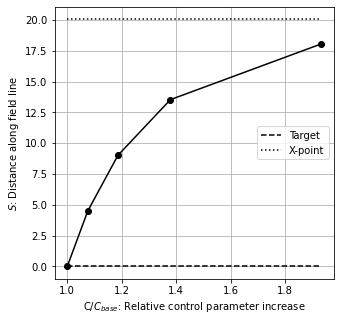

In [5]:
Crel = Cf/Cf[0]
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(Crel, Sf, color = "black", marker = "o")
ax.hlines(0, Crel[0], Crel[-1], color = "black", linestyle = "dashed", label = "Target")
ax.hlines(d["S"][d["Xpoint"]], Crel[0], Crel[-1], color = "black", linestyle = "dotted", label = "X-point")
ax.legend(loc="right")
ax.set_xlabel("C/$C_{base}$: Relative control parameter increase"); 
ax.set_ylabel("$S$: Distance along field line")
ax.grid(which="both")


# Lengyel Reinke Formulation

In [11]:
#set switches
radios = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 5*10**9, # heat flux density at the x point
    "nu" : 1*10**19, #upstream density
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncN, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
    "XpointIndex":d["Xpoint"]-1, # Index of Xpoint
    "B":interpolate.interp1d(d["S"], d["TotalField"], kind='cubic') # Continuous function for B
}

cases = dict()

In [7]:
np.linspace(0,len(d["S"])-1000,5)

array([   0., 2250., 4500., 6750., 9000.])

In [38]:
indexpoints = [2250]
#set switches
radios = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 5*10**9, # heat flux density at the x point
    "nu" : 1*10**19, #upstream density
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncN, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
    "XpointIndex":int(len(d["S"]))-2, #int(len(d["S"])*0.8), # Index of Xpoint
    "B":interpolate.interp1d(d["S"], d["TotalField"], kind='cubic') # Continuous function for B
}
splot,C,Sprofiles,Tprofiles,Qprofiles, log = returnImpurityFracLeng(constants,radios,d["S"],indexrange)
print("complete")
name = "N"
cases[name] = dict()
cases[name]["C"] = C
cases[name]["Crel"] = C/C[0]

Solving...0...2250...4500...6750...9000...Complete.
complete


In [39]:
constants_new = constants.copy()
constants_new["Lfunc"] = LfuncAr

splot,C,Sprofiles,Tprofiles,Qprofiles, log = returnImpurityFracLeng(constants_new,radios,d["S"],indexrange)
print("complete")
name = "Ar"
cases[name] = dict()
cases[name]["C"] = C
cases[name]["Crel"] = C/C[0]

Solving...0...2250...4500...6750...9000...Complete.
complete


In [40]:
constants_new = constants.copy()
constants_new["Lfunc"] = LfuncNe

splot,C,Sprofiles,Tprofiles,Qprofiles, log = returnImpurityFracLeng(constants_new,radios,d["S"],indexrange)
print("complete")
name = "Ne"
cases[name] = dict()
cases[name]["C"] = C
cases[name]["Crel"] = C/C[0]

Solving...0...2250...4500...6750...9000...Complete.
complete


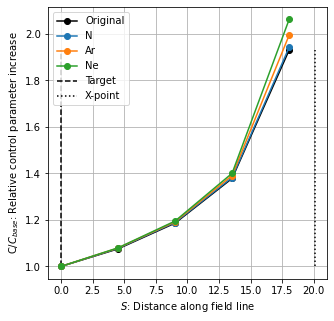

In [43]:
Crel = Cf/Cf[0]
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(Sf, Crel, color = "black", marker = "o", label = "Original")

for case in ["N", "Ar", "Ne"]:
    ax.plot(splot,cases[case]["Crel"], label = case, marker = "o")

ax.vlines(0, Crel[0], Crel[-1], color = "black", linestyle = "dashed", label = "Target")
ax.vlines(d["S"][d["Xpoint"]], Crel[0], Crel[-1], color = "black", linestyle = "dotted", label = "X-point")
ax.legend(loc="best")
ax.set_ylabel("C/$C_{base}$: Relative control parameter increase"); 
ax.set_xlabel("$S$: Distance along field line")
ax.grid(which="both")


In [32]:
cases2 = dict()

In [33]:
constants_new = constants.copy(); radios_new = radios.copy()
constants_new["Lfunc"] = LfuncN
constants_new["XpointIndex"] = 7000

splot,C,Sprofiles,Tprofiles,Qprofiles, log = returnImpurityFracLeng(constants_new,radios,d["S"],indexrange)
print("complete")
cases2["N"] = {"C":C, "Crel":C/C[0]}

Solving...0...2250...4500...6750...9000...Complete.
complete


In [34]:
constants_new = constants.copy(); radios_new = radios.copy()
constants_new["Lfunc"] = LfuncN
constants_new["XpointIndex"] = 7000

splot,C,Sprofiles,Tprofiles,Qprofiles, log = returnImpurityFracLeng(constants_new,radios,d["S"],indexrange)
print("complete")
cases2["Ar"] = {"C":C, "Crel":C/C[0]}

Solving...0...2250...4500...6750...9000...Complete.
complete


In [35]:
constants_new = constants.copy(); radios_new = radios.copy()
constants_new["Lfunc"] = LfuncN
constants_new["XpointIndex"] = 7000

splot,C,Sprofiles,Tprofiles,Qprofiles, log = returnImpurityFracLeng(constants_new,radios,d["S"],indexrange)
print("complete")
cases2["Ne"] = {"C":C, "Crel":C/C[0]}

Solving...0...2250...4500...6750...9000...Complete.
complete


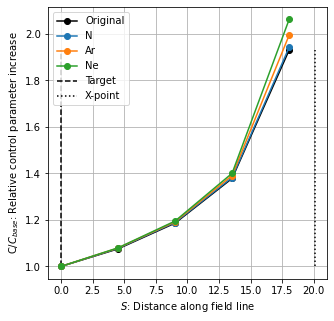

In [42]:
Crel = Cf/Cf[0]
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(Sf, Crel, color = "black", marker = "o", label = "Original")

for case in cases2.keys():
    ax.plot(splot,cases[case]["Crel"], label = case, marker = "o")

ax.vlines(0, Crel[0], Crel[-1], color = "black", linestyle = "dashed", label = "Target")
ax.vlines(d["S"][d["Xpoint"]], Crel[0], Crel[-1], color = "black", linestyle = "dotted", label = "X-point")
ax.legend(loc="best")
ax.set_ylabel("C/$C_{base}$: Relative control parameter increase"); 
ax.set_xlabel("$S$: Distance along field line")
ax.grid(which="both")


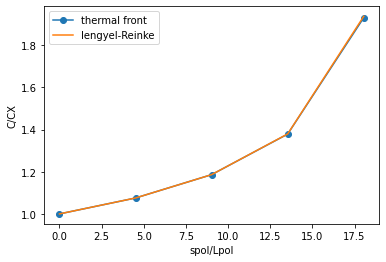

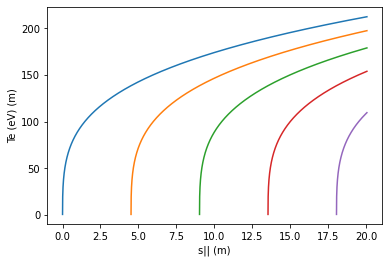

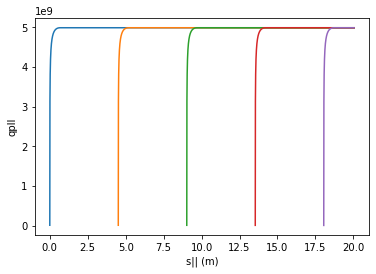

In [92]:
# %%
B =  interpolate.interp1d(S, TotalField, kind='cubic') # Why interpolate?

constants["XpointIndex"] = Xpoint
constants["B"] = interpolate.interp1d(S, TotalField, kind='cubic')

#calculate C using the Lengyel-Reinke model
splot,C,Sprofiles,Tprofiles,Qprofiles = returnImpurityFracLeng(constants,radios,S,indexrange)
# %%

# compare models against eachother
plt.plot(Sf,Cf/Cf[0],label="thermal front",color="C0",marker="o")
plt.plot(splot,C/C[0],label="lengyel-Reinke",color="C1")
plt.xlabel("spol/Lpol")
plt.ylabel("C/CX")
plt.legend()
plt.savefig("ControlParameter.png",dpi=400)
plt.show()

#plot temperature profiles from Lengyel-Reinke model
for i in range(len(Tprofiles)):
    plt.plot(Sprofiles[i],Tprofiles[i])
plt.ylabel("Te (eV) (m)")
plt.xlabel("s|| (m)")
plt.show()

#plot heat flux profiles from Lengyel-Reinke model
for i in range(len(Qprofiles)):
    plt.plot(Sprofiles[i],Qprofiles[i])
plt.ylabel("qpll")
plt.xlabel("s|| (m)")
plt.show()
# %%

In [59]:
B(4)

array(0.50503621)